# MEHDAOUI Abderrahim 
# Partie 1 du TP

## 2 - Generation of synthetic data

### Question 1 et importation des packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

# Importation du signal
xbar = np.genfromtxt('signal.txt', usecols=0, dtype=float)

### Question 2

In [2]:
N = 200
Tmin = 1
Tmax = 1000
T = []
logT=np.log(Tmin/Tmax)
logT = logT/(N-1)
for i in range(200):
    Tval=Tmin*np.exp(-i*logT)
    T.append(Tval)

### Question 3 

<function matplotlib.pyplot.show(*args, **kw)>

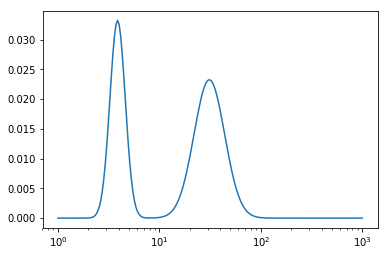

In [3]:
fig = plt.plot(T,xbar)
plt.xscale("log")
plt.show

### Question 4

In [4]:
M = 50
tmin = 0
tmax = 1.5
t = []
for m in range(1,M+1):
    tval=tmin+((m-1)/(M-1))*(tmax-tmin)
    t.append(tval)

### Question 5

In [5]:
Tmat = np.asmatrix(T)
tmat = np.asmatrix(t)
t_trans = np.transpose(tmat)
temp = t_trans.dot(Tmat)
K = np.exp(-temp)

### Question 6

In [6]:
xbarmat = np.transpose(np.asmatrix(xbar))
Kx=np.dot(K,xbarmat)
sigma=0.01*Kx[0]
w=sigma*np.random.randn(50)
y = Kx+np.transpose(w)

### Question 7

<function matplotlib.pyplot.show(*args, **kw)>

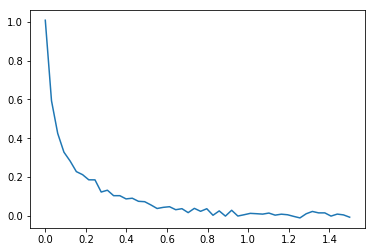

In [7]:
fig2 = plt.plot(np.transpose(t),y)
plt.show

## 3 - Comparison of regularization strategies

Maintenant que le signal est créé, nous allons tenter de résoudre le problème d'optimisation avec 3 fontions de pénalisation g(x) différentes. Elles sont définies ci-dessous.

Smoothness prior : 
$$ g(x) = \frac{1}{2}||Dx||^2 $$
Smoothness prior + constraints :
$$ g(x) = \frac{1}{2}||Dx||^2 + i_{[xmin,xmax]}(x) $$
Sparcity prior :
$$ g(x) = ||x||_1 $$

In [8]:
#Calcule l'erreur entre la solution trouvée et le signal
def errquadra(x,sol):
    if x.shape != sol.shape:
        return 'pb de dimension'
    return (np.linalg.norm(x-sol)**2/np.linalg.norm(x,2)**2)

### Smoothness prior

$$ \hat{x}= argmin \frac{1}{2}||Kx-y||^2 +\beta (\frac{1}{2}||Dx||^2 $$

Existence et unicité de la solution  : La solution existe et est unique puisque la fonction à minimiser est strictement convexe par somme de fonction convexe et strictement convexe.

Le problème possède d'ailleurs une solution analytique qu'on explicite ci-dessous.

$$ L(x) = \frac{1}{2}||Kx-y||^2 +\frac{\beta}{2}||Dx||^2 $$
On résout $$ \frac{\partial L}{\partial x}(x=x^*) = K^T (Kx^* -y)+\beta D^T Dx^* =0 $$
$$ \rightarrow (K^T K + \beta D^T D)x^* = K^T y $$
$$ \rightarrow x^* = (K^T K + \beta D^T D)^{-1} K^T y $$

In [9]:
betalist = [1e-5, 5e-5, 1e-4, 1e-3, 1e-2, 1e-1,0.3,0.5,1,3,7,10,25]
xgood = 0
bgood = 0
err = 100000

Kt = np.transpose(K)
KtK = Kt.dot(K)

#definition de D
D = np.eye(N)
D[0][N-1]=-1
for i in range(1,N):
    D[i][i-1]=-1
    
DtD = np.transpose(D).dot(D)

for beta in betalist:
    xestim = np.linalg.inv((KtK+beta*DtD)).dot(Kt).dot(y)
    errestim = errquadra(xbarmat, xestim)
    if errestim < err:
        err = errestim
        xgood = xestim
        bgood = beta

In [10]:
#Affichage de l'erreur quadratique minimale et du beta correspondant
print('erreur minimale : ' + str(err))
print('beta optimal ' + str(bgood))

erreur minimale : 0.14016248409178267
beta optimal 0.5


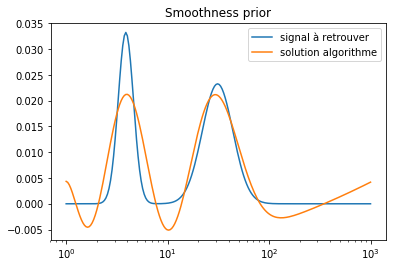

In [11]:
#Comparaison des deux signaux
plt.plot(T,xbar)
plt.plot(T,xgood)
plt.xscale("log")
plt.title('Smoothness prior')
plt.legend(['signal à retrouver','solution algorithme'])

Cette réponse est variable en fonction du bruit. On n'obtient des valeurs de beta très différentes selon la sortie du bruit.
On a même parfois des valeurs négatives pour la solution de l'algorithme. 
La valeur de beta qui minimise l'erreur est ici de 1.

### Smoothness prior + constraints

$$ \hat{x}= argmin \frac{1}{2}||Kx-y||^2 +\beta \left( \frac{1}{2}||Dx||^2 + i_{[xmin,xmax]}(x) \right) $$

Existence et unicité : La solution existe et est unique car la fonction à minimiser est strictement convexe par somme de fonction convexe et strictement convexe. 

On sépare cette fonction en 2 fonctions :
$$ \hat{x}= argmin (f(x)+g(x)) $$
avec f non différentiable et g différentiable :
$$ f(x)= \beta i_{[xmin,xmax]}(x) $$
$$ g(x)= \frac{1}{2}||Kx-y||^2 +\beta \frac{1}{2}||Dx||^2 $$

On a C=[xmin,xmax] un sous ensemble de R, la fonction g(x) est différentiable et lipschitzienne. Nous savons qu'une solution de ce problème existe sur C. On utilise donc la méthode du gradient projeté. 

$$  y_{n}=x_{n}-\gamma \nabla g(x_{n}) $$
$$ x_{n+1}=x_{n}+\lambda (P_{C}y_{n}-x_{n}) $$

Avec : 

$$ \nabla g(x)=K^T (Kx-y) +\beta D^T Dx$$

$$\begin{equation*}
    P_{C}(y_{n} = \begin{cases}
               x_{min}      & y_{n} < x_{min}\\
               x_{max}      & y_{n} > x_{max}\\
               y_{n}        & \text{sinon}
           \end{cases}
\end{equation*} $$

In [12]:
def grad(x, beta):
    return KtK.dot(x) + beta*DtD.dot(x) - Kt.dot(y)
def proj(x):
    return np.matrix(np.clip(x, np.amin(xbar),np.amax(xbar)))

In [13]:
def grad_proj(beta):
    L = np.max(np.linalg.eigvals(KtK + beta*DtD))
    gamma = 0.999*2/L
    delta = 2-gamma*L/2
    lmb = delta*0.999
    
    xn = np.zeros([N,1]) #initialisation
    tol = 1e-4
    it = 0
    it_max = 40000
    converged = False
    
    while converged == False and it<it_max:
        it += 1
        yn = xn - gamma*grad(xn,beta)
        xnp1 = xn + lmb*(proj(yn)-xn)   
        if errquadra(xn,xnp1)<tol:
            Converged = True
        xn = xnp1  
    #print('pour beta = '+str(beta))
    #print(it)
    return xnp1

In [14]:
err = 10000
bgood2 = 0
xgood2 = []
for b in betalist:
    xestim = grad_proj(b)
    errtest = np.linalg.norm(xbarmat-xestim)**2/np.linalg.norm(xbarmat)**2
    if errtest<err:
        err = errtest
        bgood2 = b
        xgood2 = xestim

/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [15]:
print('erreur minimale : ' +str(err))
print('beta optimal ' + str(bgood2))

erreur minimale : 0.031548370858901144
beta optimal 0.01


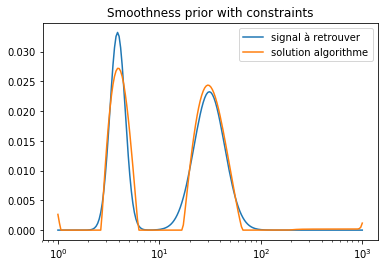

In [16]:
#Comparaison des deux signaux
plt.plot(T,xbar)
plt.plot(T,xgood2)
plt.xscale("log")
plt.title('Smoothness prior with constraints')
plt.legend(['signal à retrouver','solution algorithme'])

Cette méthode est de plus en plus précise lorsqu'on augmente le nombre d'itérations (ici 40k pour éviter d'attendre trop). De plus, la solution approchée ne possède pas de valeurs négatives

La valeur de beta qui minimise l'erreur est de 0.3. On apporte donc plus d'importance à la similitude au signal observé qu'à la régularisation de la fonction. Quand on compare les deux signaux, la solution trouvée est proche de la réalité. Les deux pics sont bien situés et d'amplitude très proche, on identifie quand donc bien les 2 composants.

### Sparsity prior

$$ \hat{x}= argmin \frac{1}{2}||Kx-y||^2 +\beta ||x||_{1}$$

Existence et unicité de la solution : cf smoothness prior + constraints


On sépare cette fonction en 2 fonctions :
$$ \hat{x}= argmin f(x) + g(x) $$
avec f non différentiable et g différentiable :
$$ f(x)= \beta ||x||_{1} $$
$$ g(x)= \frac{1}{2}||Kx-y||^2 $$

Ici g(x) n'est pas différentiable en 0. On peut donc utiliser l'algorithme de Forward Backward.
$$ y_{n}=x_{n}-\gamma \nabla g(x_{n}) $$
$$ x_{n+1}=x_{n} +\lambda_{n}(prox_{\gamma f}y_{n}-x_{n}) $$

Avec :
$$ \nabla g(x)=K^T(Kx-y) $$
$$ prox_{\gamma f}y_{n}=argmin \gamma f(y) +\frac{1}{2} ||y-y_{n}||^2 $$
$$ \beta \gamma |p_{f}| +p_{f}-y_{n}=0 $$
$$ p_{f}= y_{n}-max(0,|y_{n}|- \gamma *\beta) $$



In [17]:
def prox(x, beta, gamma): #vu en cours
    return np.multiply(np.sign(x), np.maximum(np.abs(x)-beta*gamma,0))

def grad_sparsity(x):
    return KtK.dot(x) - Kt.dot(y)

In [18]:
def forward_backward(beta):
    L = np.max(np.linalg.eigvals(KtK+beta*DtD))
    gamma = 2/L*0.999
    delta = 2 - gamma*L/2
    lmb = delta*0.999
    
    xn = np.zeros([N,1]) #initialisation
    tol = 1e-5
    it = 0
    it_max = 40000
    converged = False
    
    while converged == False and it<it_max:
        it +=1
        yn = xn-gamma*grad_sparsity(xn)
        xnp1 = xn+lmb*(prox(yn, beta, gamma)-xn)
        if errquadra(xn,xnp1)<tol:
            converged = True
        xn = xnp1
    #print('pour beta = '+str(beta))
    #print(it)
    return xnp1

In [19]:
err= 10000
bgood3 = 0
xgood3 = []
for b in betalist:
    xestim = forward_backward(b)
    errtest = errquadra(xbarmat,xestim)
    if errtest<err:
        err = errtest
        bgood3 = b
        xgood3 = xestim

/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [20]:
print('erreur minimale : ' + str(err))
print('beta optimal ' + str(bgood3))

erreur minimale : 0.2394974224651324
beta optimal 0.0001


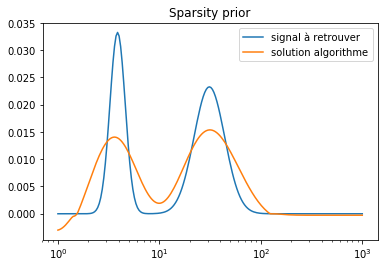

In [21]:
#Comparaison des deux signaux
plt.plot(T,xbar)
plt.plot(T,xgood3)
plt.xscale("log")
plt.title('Sparsity prior')
plt.legend(['signal à retrouver','solution algorithme'])

L'hyperparamètre optimal beta est 1e-4. 
L'amplitude des pics n'est pas similaire mais permet d'identifier les composants de manière approchée.
On remarque  l'algorithm converge plus rapidment avec la fonction sparsity (1536 contre 40k+).

# TP Partie 2

### Question 1

$$ \hat{x}= argmin \frac{1}{2}||Kx-y||^2 +\beta ent(x) $$
avec
$$ \forall x \in \mathbb{R}^{N}, ent(x)= \sum \varphi (x^{(n)}) $$
et
$$\begin{equation*}
    \varphi (u) = \begin{cases}
               u \log{(u)}    & u > 0\\
               0            & u = 0\\
               + \infty     & \text{sinon}
           \end{cases}
\end{equation*} $$


Cette fonction est convexe, en effet :
$$ si u>0, \phi '' (u)=\frac {1}{u}>0 $$

Cette fonction est propre car son domaine est non vide. En effet :
$$ dom_{\phi}= [0,+ \infty [ $$

Cette fonction est semi-continue car son épigraphe est fermé.

Cette fonction n'est pas différentiable en 0, donc elle n'est pas différentiable.


### Question 2 

La fonction à minimiser est propre, semi-continue positive et coercive. D'après le théorème d'existence, il existe une solution à ce problème d'optimisation. 

La fonction à minimiser est strictement convexe par somme de fonction convexe et strictement convexe. Donc la solution est unique. 

### Question 3

On a :
$$ prox_{\gamma ent}(x) = prox_{\gamma}(\varphi (x^{(i)})_{i \in [1,N]}$$
$$ prox_{\gamma ent}(u) = argmin_{v \in R} \left( \frac{1}{2} (v-u)^{2} + \gamma v \log{(v)} \right) $$
$$ \frac {dh}{du} (v) = v-u + \gamma (\log{(v)}+1) $$
$$ 0 = \frac {dh}{du} (v) \Longleftrightarrow  \frac {1}{\gamma} \exp{ \left( \frac {u}{\gamma} \right) } = \frac {v}{\gamma} \exp{\left( \frac {v}{\gamma} +1 \right)}$$
$$ \Longleftrightarrow  \frac {v}{\gamma} \exp{\left(\frac {v}{\gamma} \right)} = \exp{\left( \frac {u}{\gamma} -1 - \log{(\gamma)} \right)}$$
$$ \Rightarrow v = \gamma W \left( \exp{\left( \frac {u}{\gamma} -1 - \log{(\gamma)} \right)} \right) $$

### Question 4 

Afin de résoudre ce problème d'optimisation, on sépare la fonction à minimiser en 2 fonctions :
$$ \hat{x} = argmin \left( f(x) + g(x) \right) $$
avec f différentiable et g non différentiable :
$$ f(x)= \frac{1}{2}||Kx-y||^2 $$
$$ g(x)= \beta ent(x) $$

On peut donc appliquer les algorithmes Forward Backward et de Douglas Rachford : 
<ul>
<li>Forward-Backward
$$ y_{n}=x_{n}-\gamma \nabla g(x_{n}) $$
$$ x_{n+1}=x_{n} +\lambda_{n}(prox_{\gamma f}y_{n}-x_{n}) $$ </li>
<li>Douglas Rachford
$$ y_{n}=prox_{\gamma g}(x_{n}) $$
$$ z_{n}=prox_{\gamma f}(2y_{n}-x_{n}) $$
$$ x_{n+1}=x_{n} +\lambda_{n}(z_{n}-x_{n}) $$ </li>
</ul>

Nous avons donc besoin de calculer les prox des fonctions γf et γg :
$$ p_{\gamma g}=\beta \gamma W \left( \frac{1}{\beta \gamma} exp(\frac{x}{\beta \gamma}-1) \right)$$

$$ p_{\gamma f} = \left(\gamma K^T K + Id)^{-1} (x+ \gamma K^T y \right) $$

On a donc :
<ul>
<li>Forward-Backward
$$ y_{n}= x_{n} -\gamma K^T(Kx_{n}-y) $$
$$ x_{n+1}= x_{n} +\lambda_{n}(\beta \gamma W \left( \frac{1}{\beta \gamma} exp(\frac{y_{n}}{\beta \gamma}-1))-x_{n} \right) $$</li>
<li>Douglas Rachford
$$ y_{n}=(Id+ \gamma K^T K)^{-1} (x_{n}+ \gamma K^T y) $$
$$ z_{n}=\beta \gamma W(\frac{1}{\beta \gamma} exp(\frac{(2y_{n}-x_{n})}{\beta \gamma}-1)) $$
$$ x_{n+1}=x_{n} +\lambda_{n}(z_{n}-x_{n}) $$ </li>
</ul>

In [22]:
KtK = Kt.dot(K)
prox_f = lambda x : np.linalg.inv(KtK+np.eye(N)).dot(x+Kt.dot(y))
prox_g = lambda u, beta, gamma : gamma*beta*np.real(scipy.special.lambertw(1/(beta*gamma)*np.exp(u/(beta*gamma)-1), 0))

In [23]:
def douglas_rashford(beta, gamma):
    converged = False
    it_max = 25000
    it = 0
    lmb = 1/2
    xn = np.zeros([N,1])
    tol = 1e-5
    while it < it_max and converged == False:
        it += 1
        yn = prox_g(xn, beta, gamma)
        zn = prox_f(2*yn-xn)
        xnp1 = xn + lmb*(zn-yn)
        if errquadra(xn, xnp1)<tol:
            converged = True
        xn = xnp1
    #print('pour beta, gamma = '+str(beta)+' ,'+str(gamma))
    #print(it)
    return xnp1

In [24]:
err = 10000
bgood4 = 0
gamgood = 0
xgood4 = []
for b in betalist:
    for g in [0.5,1,1.5]:
        xestim = douglas_rashford(b,g)
        errtest = errquadra(xbarmat,xestim)
        if errtest<err:
            err = errtest
            bgood4 = b
            xgood4 = xestim
            gamgood = g

/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()
/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


In [25]:
print('erreur minimale : ' + str(err))
print('beta optimal : ' + str(bgood4))
print('gamma optimal : ' + str(gamgood))

erreur minimale : 0.08141474570127581
beta optimal : 5e-05
gamma optimal : 1


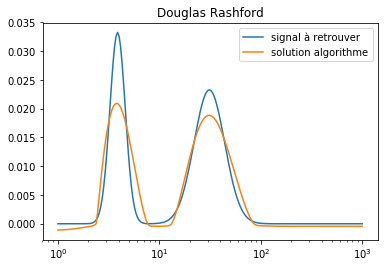

In [26]:
plt.plot(T,xbar)
plt.plot(T,xgood4)
plt.xscale("log")
plt.title('Douglas Rashford')
plt.legend(['signal à retrouver', 'solution algorithme'])

In [27]:
def forward_backward2(beta):
    L = np.max(np.linalg.eigvals(KtK))
    gamma = 2/L*0.999
    delta = 2 - gamma*L/2
    lmb = 1/2
    
    grad = lambda x : KtK.dot(x)-Kt.dot(y)
    
    xn = np.zeros([N,1]) #initialisation
    tol = 1e-5
    it = 0
    it_max = 40000
    converged = False
    
    while converged == False and it<it_max:
        it +=1
        yn = xn-gamma*grad(xn)
        xnp1 = xn+lmb*(prox_g(yn, beta, gamma)-xn)
        if errquadra(xn,xnp1)<tol:
            converged = True
        xn = xnp1
    #print('pour beta = '+str(beta))
    #print(it)
    return xnp1

In [28]:
err= 10000
bgood5 = 0
xgood5 = []
for b in betalist:
    xestim = forward_backward2(b)
    errtest = errquadra(xbarmat,xestim)
    if errtest<err:
        err = errtest
        bgood5 = b
        xgood5 = xestim

/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [29]:
print('erreur minimale : ' + str(err))
print('beta optimal : ' + str(bgood5))

erreur minimale : 0.6217002302173559
beta optimal : 0.01


/Users/abderrahim/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


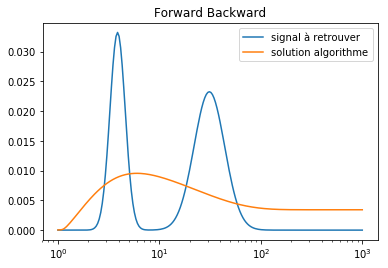

In [30]:
plt.plot(T,xbar)
plt.plot(T,xgood5)
plt.xscale("log")
plt.title('Forward Backward')
plt.legend(['signal à retrouver', 'solution algorithme'])

On voit clairement que le forward backward est moins perofrmant.
De plus, pour certains valeurs de beta trop faible on obtient un overflow avec l'exponentielle. 

## Avec $$\beta = 10^{-2}$$

In [31]:
FB = forward_backward2(10**-2)
DR = douglas_rashford(10**-2,1)
print("erreur avec Douglas-Rashford")
print(errquadra(xbarmat,DR))
print("erreur avec Forward-Backward")
print(errquadra(xbarmat,FB))

erreur avec Douglas-Rashford
20.15955386408167
erreur avec Forward-Backward
0.6217002302173559


/Users/abderrahim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


/Users/abderrahim/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


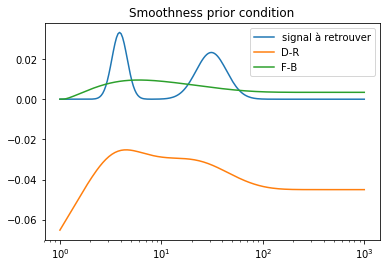

In [32]:
plt.plot(T,xbar)
plt.plot(T,DR)
plt.plot(T,FB)
plt.xscale("log")
plt.title('Smoothness prior condition')
plt.legend(['signal à retrouver', 'D-R', 'F-B'])

Même si le signal estimé via Douglas-Rashford est plus proche de la courbe, on ne peut pas déterminer les deux composants avec $$ \beta = 10^{-2} $$

### Question 7

0.086 Smoothness + constraints (en fonction du bruit on a parfois atteint 0.04) <br>
0.088 D-R <br>
0.184 Smoothness <br>
0.2 Sparsity <br>
0.624 F-R <br>

On constate que le meilleur résultat est obtenu via la fonction de régulariasation Smoothness + constraints suivi d par le résultat obtenu via D-R. Donc ajouter un terme d'entropie n'est pas une mauvaise idée mais il faut bien choisir l'algorithm de résolution car on voit par exemple que le pire résultat est obtenu via l'algorithm F-R (avec un terme d'entropie).

### Question 8

On veut : 
$$ \min_{x\in\mathbb{R}^N} ent(x),\ \text{s.c}\ \| Kx-y \|^2 \le \eta M \sigma^2 $$
Avec $\eta > 0$

$$ \Longrightarrow \min_{x\in\mathbb{R}^N} ent(x) + \iota_{D}(Kx),$$
Avec $D = \overline{B}_{\sigma\sqrt{\eta M}}(y)$

Dans ce cas, on a $g(x) = g_1(x)+g_2(x)$, avec $g_1(x)=ent(x)$ et $g_2(x)=\iota_D(x)$. 
Avec $L_1 = \mathrm{Id}$ et $L_2 = K$.

On a déjà le prox de g1. <br>
Pour g2 : 
$$prox_{\gamma g_2}(x)$$ est le projeté de $$\iota_{D}(Kx)$$ sur $$\overline{B}_{\sigma\sqrt{\eta M}}(y)$$

In [33]:
def ppxa(gamma, eta):
    sigma2 = sigma**2
    
    proxg1 = lambda x: gamma*np.real(scipy.special.lambertw(1/(gamma)*np.exp(x/gamma-1), 0))
    proxg2 = lambda x: y + ((x-y)/np.linalg.norm(x-y))*min(1,(np.sqrt(sigma2*eta*M)))

    lmb = 1/2
    itmax = 20000
    it = 0 
    Converged = False
    tol = 1e-5
    
    temp = np.linalg.inv(KtK+np.eye(N))
    
    xn1 = np.zeros([N,1])
    xn2 = np.zeros([M,1])
    vn = temp.dot(xn1+Kt.dot(xn2))
    
    while it < itmax and Converged == False:
        it += 1
        yn1 = proxg1(xn1)
        yn2 = proxg2(xn2)
        
        cn = temp.dot(yn1+Kt.dot(yn2))
        
        xnp11 = xn1 + lmb*(2*cn-vn-yn1)
        xnp12 = xn2 + lmb*(K.dot(2*cn-vn)-yn2)
        
        vnp1 = vn+lmb*(cn-vn)
        
        #if errquadra(vn,vnp1)<tol:
        #    Converged = True
        if np.linalg.norm(vn-vnp1,1) < tol*np.linalg.norm(vn,1):
            Converged = True        
        vn = vnp1
        xn1 = xnp11
        xn2 = xnp12
    return vn

In [34]:
err= 10000
etagood = 0
gamgood2 = 0
xgood6 = []
for eta in betalist:
    for gamma in [0.1, 0.5, 1, 1.5]:
        xestim = ppxa(gamma,eta)
        errtest = errquadra(xbarmat,xestim)
        if errtest<err:
            err = errtest
            etagood = eta
            gamgood2 = gamma
            xgood6 = xestim

KeyboardInterrupt: 

In [ ]:
print('erreur minimale : ' + str(err))
print('eta optimal : ' + str(etagood))
print('gamma optimal : ' + str(gamgood2))

In [ ]:
plt.plot(T,xbar)
plt.plot(T,xgood6)
plt.xscale("log")
plt.title('Smoothness prior condition')
plt.legend(['signal à retrouver', 'D-R', 'F-B'])